# Model errors and feature importances are calculated in `BJA-3.8.1`

In [363]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-white')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'
sns.set_style('white')
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox

import json
from decimal import Decimal

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

## Process the model results file in one way for the boxplots

In [370]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', 
                index_col=0).rename({'x': 'Sampling'}, axis=1)
r['Sampling'] = r['Sampling'].replace('Fed', 'Non-fasted')
# r['model'] = r['model'].map({'ols': 'OLS', 'lasso': 'LASSO (L1)', 'ridge': 'Ridge (L2)', 
#                                    'svm': 'SVM\nLinear kernel', 'pls': 'PLS', 'rf': 'Random\nForest'})
mse = r.melt(value_vars=r.filter(regex='neg_mean_squared_error_\d').columns, id_vars=['model', 'Sampling', 'y']) \
        .drop('variable', axis=1)
r2 = r.melt(value_vars=r.filter(regex='r2_\d').columns, id_vars=['model', 'Sampling', 'y']) \
        .drop('variable', axis=1)
mape = r.melt(value_vars=r.filter(regex='neg_mean_absolute_percentage_error_\d').columns, 
              id_vars=['model', 'Sampling', 'y']).drop('variable', axis=1)
mae = r.melt(value_vars=r.filter(regex='neg_mean_absolute_error_\d').columns, 
              id_vars=['model', 'Sampling', 'y']).drop('variable', axis=1)
ogtt = mse.loc[mse['y'] == 'ogtt'].drop('y', axis=1)
insulin = mse.loc[mse['y'] == 'insulin'].drop('y', axis=1)
weight = mse.loc[mse['y'] == 'weight'].drop('y', axis=1)

# Examples of other plots: catplot, stripplot, boxplot, boxenplot, histplot

## Boxplot overall looks good and will be good for `r2` with its crazy low outliers 

<AxesSubplot:xlabel='value', ylabel='model'>

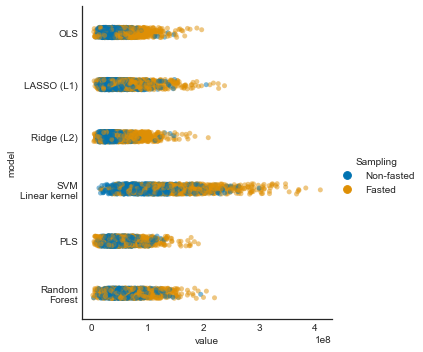

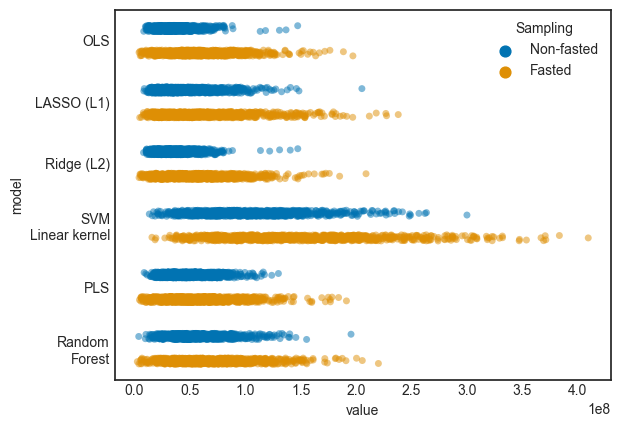

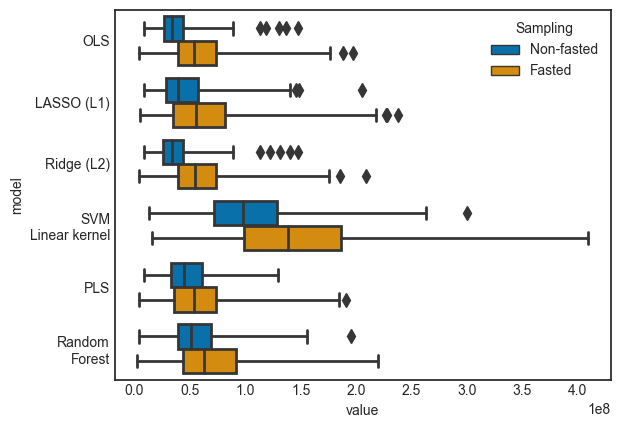

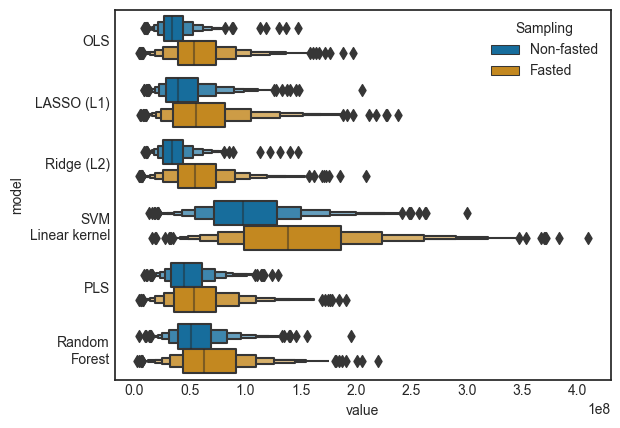

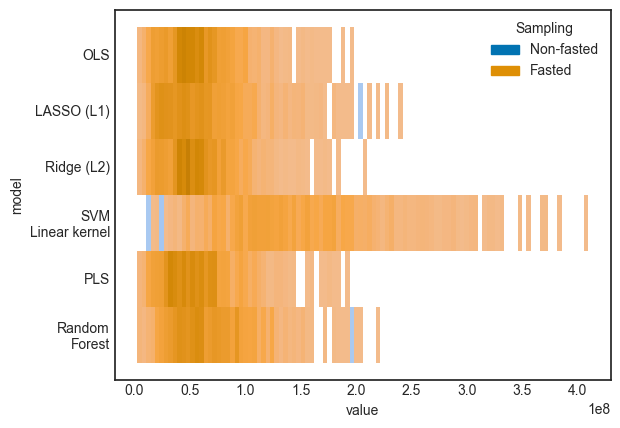

In [5]:
vp = sns.catplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
#     dodge=True,
    palette=colors, alpha=0.5,)
plt.figure()
vp = sns.stripplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
    dodge=True,
    palette=colors, alpha=0.5)
plt.figure()
vp = sns.boxplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
    width=0.8,
    linewidth=2,
    fliersize=7, whis=3,
#     scale='width',
    palette=colors, saturation=0.9,)
plt.figure()
vp = sns.boxenplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
#     scale='width',
    palette=colors, )
plt.figure()
sns.histplot(
    data=mse, x='value', y='model',
    hue='Sampling', palette=colors,)

In [374]:
r

,y,model,Sampling,neg_mean_squared_error_median,r2_median,neg_mean_absolute_percentage_error_median,neg_root_mean_squared_error_median,neg_root_mean_squared_error_mean,neg_mean_absolute_percentage_error_mean,r2_mean,...,neg_root_mean_squared_error_0990,neg_root_mean_squared_error_0991,neg_root_mean_squared_error_0992,neg_root_mean_squared_error_0993,neg_root_mean_squared_error_0994,neg_root_mean_squared_error_0995,neg_root_mean_squared_error_0996,neg_root_mean_squared_error_0997,neg_root_mean_squared_error_0998,neg_root_mean_squared_error_0999
0,ogtt,ols,Non-fasted,3.418586e+07,0.756184,0.137298,5846.867375,5932.672221,0.142928,0.657071,...,6637.280780,6295.279851,5012.392090,5203.431399,5794.853985,7736.172518,4885.495290,4788.564164,7159.026145,5520.211530
1,ogtt,ols,Fasted,5.394558e+07,0.586939,0.157827,7344.765134,7373.461372,0.164725,0.387992,...,4755.677785,3177.247041,11659.164007,10756.798257,7178.945467,7712.038913,6827.232260,10050.125957,4843.441381,8043.253275
2,ogtt,lasso,Non-fasted,3.967842e+07,0.712958,0.144648,6299.081095,6538.404775,0.157515,0.592076,...,5285.378926,7212.713300,6677.232370,6667.013943,4886.138791,5428.289633,7421.546458,5928.353825,5641.024070,5679.559399
3,ogtt,lasso,Fasted,5.586772e+07,0.568008,0.158498,7474.471079,7591.996595,0.178819,0.352454,...,6920.873324,4646.116762,9915.324435,13353.565924,4736.564046,6184.434056,5723.530848,12073.264702,4649.546814,10180.850791
4,ogtt,ridge,Non-fasted,3.390756e+07,0.757093,0.136578,5823.019405,5915.543700,0.142499,0.659173,...,6643.625849,6164.240311,5042.887831,5162.087987,5789.866332,7498.314409,4871.544544,4739.204530,7135.796827,5341.439821
5,ogtt,ridge,Fasted,5.418323e+07,0.588846,0.157841,7360.925185,7369.640214,0.164593,0.386160,...,5172.522115,3256.730218,11698.756938,10613.150771,7221.610790,7614.897032,6790.019277,10044.767929,4676.357821,8030.767855
6,ogtt,svm,Non-fasted,9.755795e+07,0.345660,0.249829,9877.125061,9899.252944,0.265500,0.203063,...,10224.439581,9641.234395,10915.761004,7621.551341,10297.453819,9233.520590,10094.554650,10196.557445,9857.831661,12099.387590
7,ogtt,svm,Fasted,1.381079e+08,0.009158,0.286012,11751.930857,11840.443155,0.308009,-0.348107,...,11942.390730,9723.823126,11272.670119,17820.731994,9384.759245,12096.256974,10707.095960,15869.961344,10068.108934,12060.703899
8,ogtt,pls,Non-fasted,4.506804e+07,0.679210,0.159187,6713.273342,6803.401673,0.163734,0.554685,...,6853.953697,5583.754360,6900.805790,6588.068455,5773.465686,10692.722019,7115.176329,5562.043556,6561.107522,4993.153679
9,ogtt,pls,Fasted,5.381503e+07,0.592421,0.152019,7335.866652,7355.938425,0.163518,0.406478,...,6553.828237,3729.836328,11781.138106,11362.294411,7263.191057,7875.746958,7467.312723,9743.087782,4767.118331,5566.761674


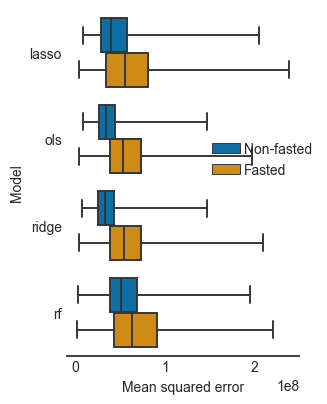

In [378]:
#### BOX PLOT VERSION ####

def plot_comparison(y, error, cut=0.4, width=0.65, whis=1.5, left=True,
                    order=['SVM\nLinear kernel', 'Random\nForest', 'PLS', 'LASSO (L1)', 'Ridge (L2)', 'OLS'],
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, ax=None,
                    loc=(0.6, 0.5),
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Sampling', 'y']) \
           .drop('variable', axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 4.5))
    p = sns.boxplot(
        data=df, x='value', y='model', hue='Sampling', ax=ax,
        orient='h', fliersize=5, whis=whis, order=order,
#         scale='width', cut=cut, width=width,
        linewidth=1.4, palette=colors, saturation=0.85,  **kwargs)
    
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Non-fasted', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Sampling'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
#             ax.annotate(error_median, xy=(annot_loc, i*(1/6)+direction*0.02), 
#                          ha='center', va='center', fontsize=14, xycoords='figure fraction')
#             ax.annotate(error_median, xy=(, i + direction*0.2), 
#                          ha='center', va='center', fontsize=14, xycoords='figure fraction')
#     plt.yticks(fontsize=14)
    ax.set_ylabel('Model', fontsize=10)
#     plt.xticks(fontsize=14)
    xlabel = error.lstrip('neg_').replace('_', ' ').capitalize()
    if xlabel == 'R2':
        xlabel = '$r^2$'
    ax.set_xlabel(xlabel, fontsize=10)
#     for y in np.arange(0.5, 5, 1):
#         plt.axhline(y=y, color='gray')
    ax.tick_params(axis='both', length=0)
#     plt.grid(axis='x', visible=None, ) 
    ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    ax.legend(loc=loc, markerscale=3, fontsize=10, frameon=False, ncol=1, handletextpad=0.3)
    sns.despine(left=left)
    
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True,
                order=['lasso', 'ols', 'ridge', 'rf'],
                error='neg_mean_squared_error',) # r2 neg_mean_absolute_percentage_error neg_mean_squared_error
                                                 
# plt.savefig(r'../reports/figures/fig6_model_feat_imp_plots/mse_boxplot.png', bbox_inches='tight', dpi=150)
# plt.savefig(r'../reports/figures/fig6_model_feat_imp_plots/mse_boxplot.pdf', bbox_inches='tight', dpi=150)

In [291]:
# plot_comparison(y='ogtt', split=False, annot_loc=0.5, left=False, showfliers=False, whis=1.5,
#                 error='r2')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/r2_boxplot.png', bbox_inches='tight', dpi=100)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/r2_boxplot.pdf', bbox_inches='tight', dpi=100)

## Process model results file in another way for the feature importance plots

In [258]:
rdf = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)
rdf = rdf.loc[(rdf['y'] == 'ogtt') & 
              (rdf['model'].isin(['ols', 'lasso', 'pls', 'rf', 'svm', 'ridge']))].drop('y', axis=1)
cols = ['model', 'x']
cols.extend(data.index)
rdf = rdf[cols]
rdf['i'] = rdf['model'] + '_' + rdf['x']
new_cols = rdf['i']
rdf = rdf.drop(['model', 'x'], axis=1)
rdf = rdf.set_index('i').T.abs()
# rdf = rdf.loc[data['ID'] != 'unknown']  # only use IDs
# rdf = rdf.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')]
rdf.loc[:, :] = MinMaxScaler().fit_transform(rdf)  # perform 0 to 1 scaling of absolute value of coefficients
rdf = rdf.join(data)
rdf = rdf.sort_values('ols_Fed', ascending=False)  # .iloc[:20]
rdf['y_point'] = range(len(rdf))  # range(len(r), 0, -1)
rdf['is_id'] = rdf['ID'] != 'Unidentified'
rdf['avg_Fed'] = rdf.filter(regex='_Fed').mean(axis=1)
rdf['avg_Fasted'] = rdf.filter(regex='_Fasted').mean(axis=1)
rdf['Molecule class'] = rdf['superclass'].map(colors)
rdf['Molecule type'] = rdf['Type'].map(colors)
# rdf

## Vertical orientation heatmap

Unidentified                   26
SM d37:1                        1
Plasmanyl-PC O-20:0_20:4        1
3-Indoxyl sulphate              1
PC 38:7                         1
PC 18:0_22:4                    1
TG 58:7                         1
SM d36:3                        1
TG 18:0_18:0_22:6               1
N6,N6,N6-Trimethyl-L-lysine     1
4-Hydroxybenzaldehyde           1
Hexose sugar                    1
Citramalic acid                 1
LysoPC 18:0                     1
TG 18:1_22:6_22:6               1
Name: ID, dtype: int64


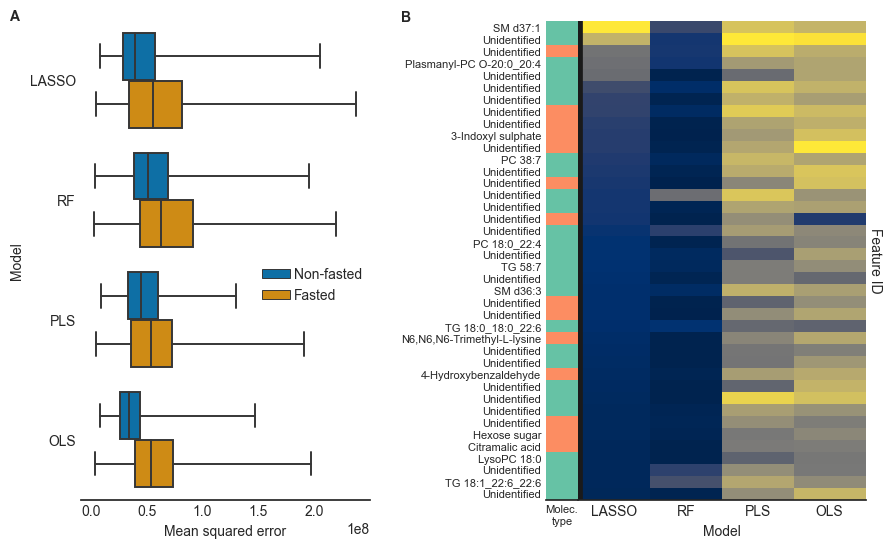

In [417]:
# fig, ax = plt.subplots(figsize=(3, 6), dpi=120)
Type = 'Fed'
models = [
    'lasso', 
    'rf',
    'pls', 
    'ols'
]
model_names = [model.upper() for model in models]
hmdf = (rdf
 .loc[:
#      (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:40]
)

cm = sns.clustermap(
    hmdf, cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False, row_colors=rdf.loc[hmdf.index, 'Molecule type'],
    colors_ratio=0.1, dendrogram_ratio=0.001, figsize=(8, 6), vmin=0, vmax=1,
    cbar_pos=None,
#     cbar_pos=(2, 0.4, 0.08, 0.4),  # (left, bottom, width, height)
#     cbar_kws={'aspect': 10},
)
hm = cm.ax_heatmap
rc = cm.ax_row_colors
cb = cm.ax_cbar

rc.set_yticks(ticks=np.arange(0.5, len(hmdf)+0.5, 1), labels=rdf.loc[hmdf.index, 'ID'], fontsize=8)
rc.set_xticklabels(labels=['Molec.\ntype'], fontsize=8, rotation=0)
hm.set_xlabel('Model')
hm.set_ylabel('Feature ID\n', rotation=270, labelpad=12)
hm.yaxis.set_label_position('right')
hm.set_yticks([])
# hm.tick_params(size=0, axis='x', pad=0.5)
hm.set_xticklabels(model_names, rotation=0)
hm.axvline(0, color='0.1', linewidth=7,)
# cb.set_title('Relative\nfeature\nimportance')

# labels = ['Lipid', 'Polar metabolite']
# handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
#            Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
# legend2 = plt.legend(handles, labels, title='Molecule type', 
#            bbox_to_anchor=(0.85, 0.2), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
# cm.fig.add_artist(legend2)

# Add models plot  # https://stackoverflow.com/questions/51811972/adding-seaborn-clustermap-to-figure-with-other-plots
cm.gs.update(left=0.6, right=1)
gs2 = plt.GridSpec(1, 1, right=0.38)
ax2 = cm.fig.add_subplot(gs2[0])
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True, ax=ax2,
                order=models, loc=(0.61, 0.4), error='neg_mean_squared_error',)
ax2.set_yticklabels([model.upper() for model in models])
for ax, letter in zip([ax2, rc], ['A', 'B']):
        bb = tight_bbox(ax)
        ax.text(x=bb.x0, y=bb.y1, s=letter, transform=cm.fig.transFigure, fontweight='bold')
print(rdf.loc[hmdf.index, 'ID'].value_counts())
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/combined.pdf', dpi=150, bbox_inches='tight', facecolor='white')
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/combined.png', dpi=150, bbox_inches='tight', facecolor='white')

In [223]:
def plot_importance(df, Type, sampling, is_id=True, num_features=20, 
                    model_ranking='ols', models=['ols', 'lasso', 'pls', 'rf'],
                    stem=False):
    """
    Type = 'lipid', 'metabolite' or '' empty string to get all 
    sampling = 'Fed' or 'Fasted'
    is_id = True for only IDs, False for only un-IDs, 
    """
    df = (df.loc[(df['is_id'] == is_id) & (df['Type'].str.contains(Type))] 
          .sort_values(f'{model_ranking}_{sampling}', ascending=False) 
          .iloc[:num_features] 
          .melt(id_vars=['ID'], value_vars=[model+'_'+sampling for model in models]) 
         )
    fig, ax = plt.subplots(figsize=(4, 1.6 + 0.4*num_features), dpi=80)
    bp = sns.barplot(
        data=df, x='value', y='ID', orient='horizontal', hue='variable',
        palette=sns.color_palette('cubehelix', len(models)),  # 'Set2' 'cubehelix', 'hls', 'husl', 'Dark2', 'brg'
        edgecolor='0.2', alpha=1, saturation=0.9, ci=None, dodge=True, ax=ax,
    )
    for patch in bp.patches:  # Set bar width, because the 'width' parameter in sns.barplot is broken 
        if stem:
            patch.set_height(0.08)
            patch.set_linewidth(0)
            bb = patch.get_bbox()
            ax.scatter([bb.x1], [bb.y1-0.05], color=patch.get_facecolor(), s=55)
        if not stem:
            patch.set_height(0.16)
        
    plt.yticks(fontsize=15)
    plt.ylabel('Identification', fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('Scaled feature importance', fontsize=15)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=[x.upper() for x in models], 
               title='Model', title_fontsize=16, 
               loc=(1.01, 0.3), fontsize=14, markerscale=2)
    # plt.axvline(1, c='gray', alpha=0.7)
#     plt.grid(axis='x', visible=None)
#     for y_pos in np.arange(ax.get_ylim()[1], ax.get_ylim()[0], len(df)):
#         ax.axhspan(y_pos)
    sns.despine(left=True)
    return bp

(9.5, -1.0)

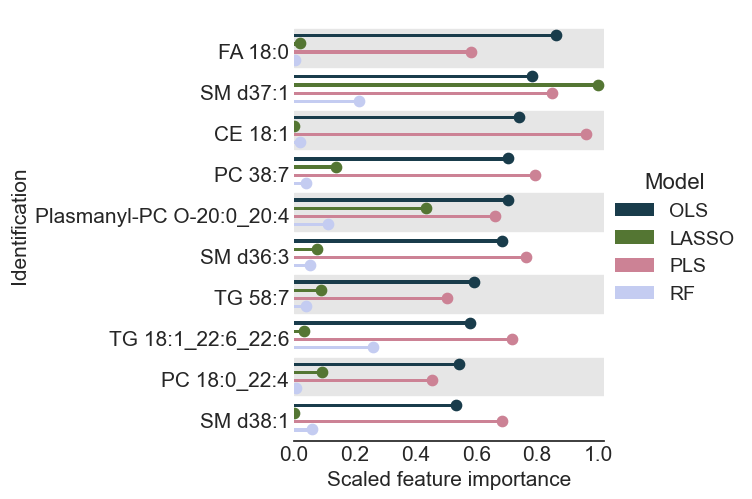

In [224]:
bp = plot_importance(df=rdf, Type='lipid', is_id=True, sampling='Fed', 
                     num_features=10, model_ranking='ols', stem=True)
fig = plt.gcf()
ax = plt.gca()
fig.set_facecolor('white')
fig.set_dpi(100)

for y_loc in ax.get_yticks()[::2]:
#     if y_loc % 2 == 1:
    ax.axhspan(ymin=y_loc-0.52, ymax=y_loc+0.4, color='0.9', zorder=-100)
ax.set_xlim(0, 1.02)
ax.set_ylim(9.5, -1)

## Horizontal heatmap orientation

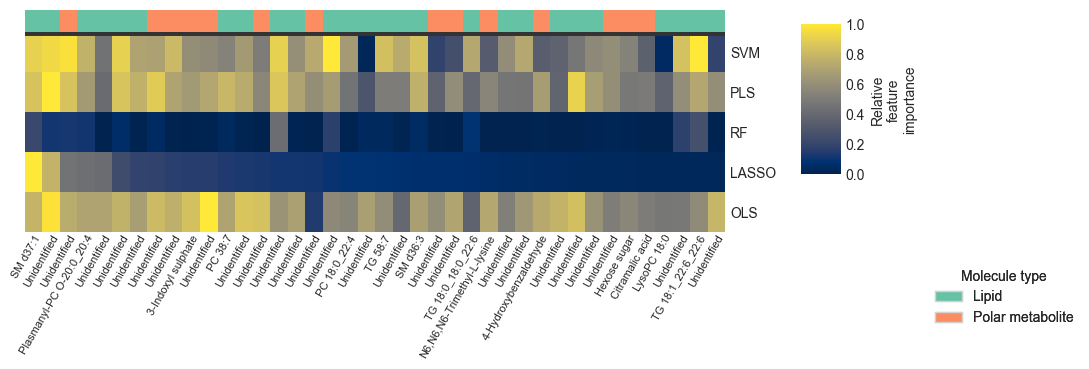

In [313]:
# fig, ax = plt.subplots(figsize=(3, 6), dpi=120)
Type = 'Fed'
models =      [ 'svm','pls', 'rf', 'lasso',  'ols',]
model_names = [ 'SVM','PLS', 'RF', 'LASSO',  'OLS',]
hmdf = (rdf
 .loc[:
#      (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:40]
)

cm = sns.clustermap(
    hmdf.T, 
    cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False,
    col_colors=(
        rdf.loc[hmdf.index, 'Molecule type'], 
#         rdf.loc[hmdf.index, 'Molecule class']
    ),
    colors_ratio=0.1, dendrogram_ratio=0.001,
    figsize=(8, 3),
    cbar_pos=(0.99, 0.4, 0.05, 0.5),  # (left, bottom, width, height)
    cbar_kws={'label': 'Relative\nfeature\nimportance'},
    vmin=0, vmax=1,
#     xticklabels=False,
#     legend=True,
)
hm = cm.ax_heatmap
hm.set_xticks(ticks=np.arange(1, len(hmdf)+1, 1), labels=rdf.loc[hmdf.index, 'ID'], 
              fontsize=8, rotation=60, ha='right', va='top');
hm.tick_params(size=0, axis='x', pad=0.5)
hm.set_yticklabels(model_names)
hm.axhline(0, color='0.2', linewidth=5,)
# cm.ax_col_colors.set_yticks([0.5, 1.5], ['Molecule type', 'Molecule class'])
cm.ax_col_colors.yaxis.tick_right()

# ADD LEGENDS TO PLOT
# handles, labels = [], []
# for superclass in rdf.loc[hmdf.index].sort_values('Type').loc[:, 'superclass'].unique():
#     s_color = colors[superclass]
#     labels.append(superclass)
#     handles.append(Patch(edgecolor='lightgray', facecolor=s_color))
# legend1 = plt.legend(handles, labels, title='Molecule class',
#            bbox_to_anchor=(1.2, 0.1), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
# cm.fig.add_artist(legend1)

labels = ['Lipid', 'Polar metabolite']
handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
           Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
legend2 = plt.legend(handles, labels, title='Molecule type', 
           bbox_to_anchor=(1.15, -0.12), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend2)

# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/Nonfasted_heatmap.pdf', dpi=150, bbox_inches='tight')
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/Nonfasted_heatmap.png', dpi=150, bbox_inches='tight')

In [ ]:
plt.colorbar

In [233]:
sns.heatmap

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

# Older versions below

(0.0, 1.0)

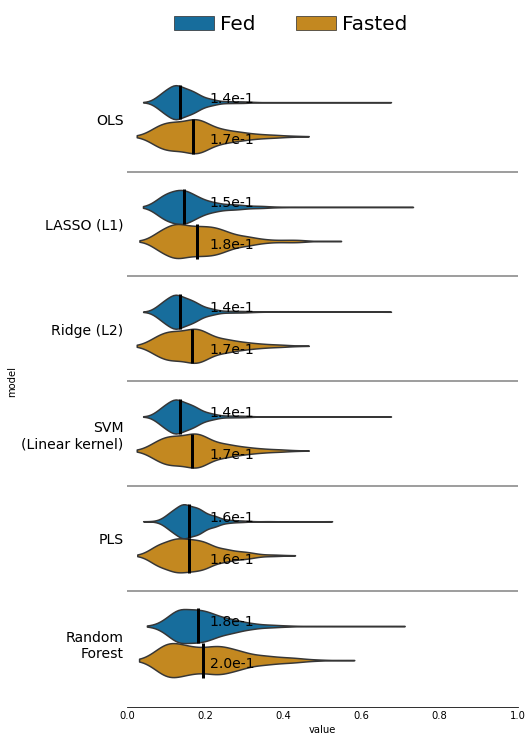

In [235]:
#### VIOLIN PLOT VERSION ####

def plot_comparison(y, error, cut=0.4, width=0.65, 
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, 
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Feeding', 'y']) \
           .drop('variable', axis=1)
    fig, ax = plt.subplots(figsize=(7, 12))
    vp = sns.violinplot(
        data=df, x='value', y='model',
        orient='h', split=split, hue='Feeding', 
        scale='width', cut=cut, width=width,
        palette=colors, inner=None, ax=ax, **kwargs)
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Fed', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Feeding'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            ax.plot([error_median, error_median], [i, i + direction*0.33], linewidth=3, color='black', solid_capstyle='butt')
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
            ax.annotate(error_median, xy=(x_point, i + direction*0.2), 
                         ha='center', va='center', fontsize=14)
    plt.yticks(fontsize=14)
#     plt.xlim(plt.xlim()[0], plt.xlim()[1]*0.8)
    for y in np.arange(0.5, 5, 1):
        plt.axhline(y=y, color='gray')
    plt.tick_params(axis='both', length=0)
    # plt.grid(axis='x', visible=None, ) 
    # ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
    sns.despine(left=True)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)
plot_comparison(y='ogtt', error='neg_mean_absolute_percentage_error', split=False)
plt.xlim(0, 1)

## It's difficult to get the `r2` plot to look OK with violin plot because it goes from -10 to 1.0
## Better would be box plot with no fliers

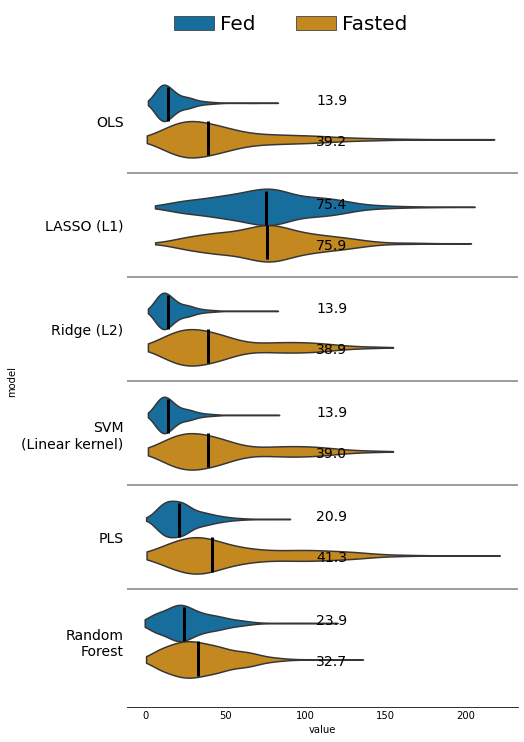

In [241]:
plot_comparison(y='weight', error='neg_mean_squared_error',
                width=0.7, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=False, round_decimal=1,
                split=False)
# plt.xlim(-0.1, 1.1)

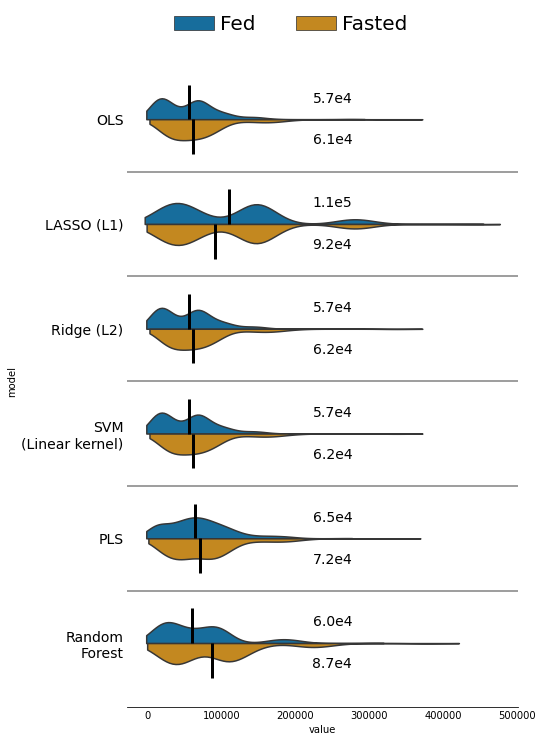

In [231]:
plot_comparison(y='insulin', error='neg_mean_squared_error',
                width=0.4, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=True)

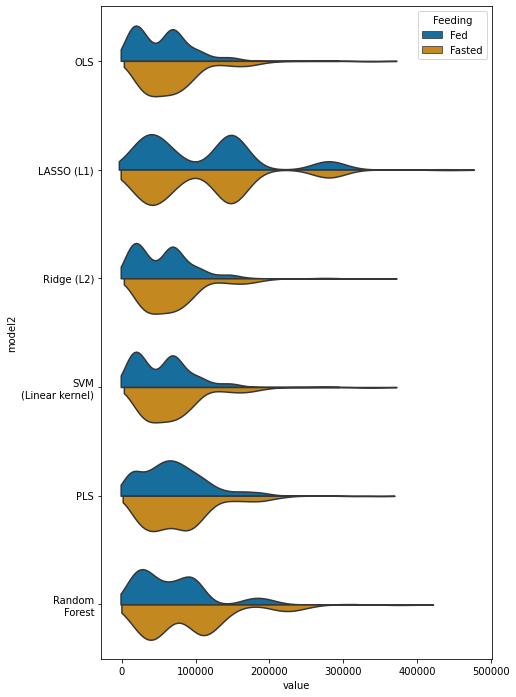

In [129]:
fig, ax = plt.subplots(figsize=(7, 12))
vp = sns.violinplot(
    data=insulin, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

In [7]:
lasso['model'] = 'lasso'
rf['model'] = 'rf'
svr['model'] = 'model'
concat = pd.concat([lasso, rf, svr])
concat['Feeding'] = concat['variable'].map({'FBG': 'Fasted', 'RBG': 'Random-fed'})
concat

,variable,value,dummy,model,Feeding
0,FBG,0.376486,dummy,lasso,Fasted
1,FBG,0.194368,dummy,lasso,Fasted
2,FBG,0.286964,dummy,lasso,Fasted
3,FBG,0.366897,dummy,lasso,Fasted
4,FBG,0.168847,dummy,lasso,Fasted
...,...,...,...,...,...
595,RBG,0.161203,dummy,model,Random-fed
596,RBG,0.153347,dummy,model,Random-fed
597,RBG,0.122726,dummy,model,Random-fed
598,RBG,0.461233,dummy,model,Random-fed


In [98]:
d = {}
for df, name in zip([lasso, rf, svr], ['lasso', 'rf', 'svr']):
    d[name] = {}
    d[name]['rbg_mean'] = df.loc[df['variable'] == 'RBG', 'value'].mean()
    d[name]['fbg_mean'] = df.loc[df['variable'] == 'FBG', 'value'].mean()

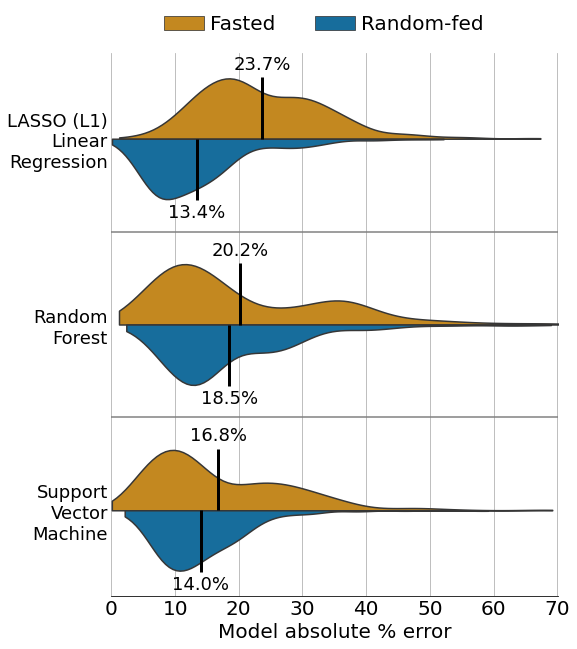

In [111]:
fig, ax = plt.subplots(figsize=(8, 10))

vp = sns.violinplot(
    data=concat, x='value', y='model',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

for i, model in enumerate(['lasso', 'rf', 'svr']):
    fbg_mean = d[model]['fbg_mean']
    rbg_mean = d[model]['rbg_mean']
    plt.plot([fbg_mean, fbg_mean], [i, i - 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.plot([rbg_mean, rbg_mean], [i, i + 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.annotate(str(round(fbg_mean*100, 1)) + '%', xy=(fbg_mean, i - 0.4), ha='center', va='center', fontsize=18)
    plt.annotate(str(round(rbg_mean*100, 1)) + '%', xy=(rbg_mean, i + 0.4), ha='center', va='center', fontsize=18)
plt.axhline(y=0.5, color='gray')
plt.axhline(y=1.5, color='gray')
plt.xlim(0, 0.701)
plt.xticks(ticks=plt.xticks()[0][:-1], labels=[str(x) for x in range(0, 80, 10)], fontsize=20)
plt.xlabel('Model absolute % error', fontsize=20)
# plt.ylabel('Model', fontsize=18)
plt.ylabel(None)
plt.yticks(ticks=[0,1,2], 
           labels=['LASSO (L1)\nLinear\nRegression', 'Random\nForest', 'Support\nVector\nMachine'],
           fontsize=18, ha='right')
plt.tick_params(axis='both', length=0)
plt.grid(axis='x', visible=None, ) 
ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
sns.despine(left=True, bottom=False)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
vp = sns.violinplot(
data=errors, x='value', y='dummy',
orient='h', split=True, hue='variable',
scale='width', cut=0.4,
palette=colors, 
inner=None, 
ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)
